# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. 
Additional datasets can be found at:
 - s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json (larger dataset located in AWS s3)
 - s3n://udacity-dsnd/sparkify/sparkify_event_data.json  (full dataset located in AWS s3)

In [3]:
#Load in data
event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(event_data)

# Exploratory Data Analysis
Here we will be exploring the data schema & values.  In particular we will be looking for qualitative characteristics from the data, and how it relates to particular users.  We will also be looking in detal for data anomolies such as missing or incomplete values (for example null userIds or sessionIds)

***KEY OUPUT***
A key output of the analysis will be how to construct a lable column identifying if a member has 'churned'

In [4]:
#Review file schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# understand unique qualitative values
df.select(['level']).dropDuplicates().show(),\
    df.select(['method']).dropDuplicates().show(),\
    df.select(['page']).dropDuplicates().show(50),\
    df.select(['status']).dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



(None, None, None, None)

In [6]:
# Understand userID format
df.groupBy(F.length(F.col('userId'))).count().orderBy('length(userId)').show()

+--------------+------+
|length(userId)| count|
+--------------+------+
|             0|  8346|
|             1| 11300|
|             2|128858|
|             3| 67340|
|             6| 70656|
+--------------+------+



In [7]:
# Understand unique userId format
df.select(df.userId).dropDuplicates().groupBy(F.length(F.col('userId'))).count().orderBy('length(userId)').show()

+--------------+-----+
|length(userId)|count|
+--------------+-----+
|             0|    1|
|             1|    8|
|             2|   88|
|             3|   56|
|             6|   73|
+--------------+-----+



In [8]:
#understand unique sessionID format
df.select(df.sessionId).dropDuplicates().groupBy(F.length(F.col('sessionId'))).count().orderBy('length(sessionId)').show()

+-----------------+-----+
|length(sessionId)|count|
+-----------------+-----+
|                1|    9|
|                2|   88|
|                3|  897|
|                4| 1360|
+-----------------+-----+



### Tools to further investigate the data by particular characteristics

In [9]:
# Understand itemsInSession
df.select(['page', 'itemInSession']).where("userId == 30 and sessionId == 29").orderBy('itemInSession').show()

+---------------+-------------+
|           page|itemInSession|
+---------------+-------------+
|       NextSong|           50|
|       NextSong|           51|
|       NextSong|           52|
|       NextSong|           53|
|Add to Playlist|           54|
|       NextSong|           55|
|       NextSong|           56|
|       NextSong|           57|
|       NextSong|           58|
|       NextSong|           59|
|       NextSong|           60|
|       NextSong|           61|
|       NextSong|           62|
|       NextSong|           63|
|       NextSong|           64|
|       NextSong|           65|
|       NextSong|           66|
|       NextSong|           67|
|       NextSong|           68|
|       NextSong|           69|
+---------------+-------------+
only showing top 20 rows



In [10]:
df.where(df.userId == 30).groupBy('sessionId').count().orderBy('sessionId').show()

+---------+-----+
|sessionId|count|
+---------+-----+
|       29|   42|
|      264|    2|
|      532|  290|
|      614|    6|
|      682|    2|
|      757|   27|
|      763|   32|
|      816|   77|
|      892|    2|
|      945|    1|
|     1110|   31|
|     1184|   33|
|     1304|    3|
|     1311|   60|
|     1340|  106|
|     1477|   79|
|     1496|   31|
|     1554|   97|
|     1574|   35|
|     1607|   28|
+---------+-----+
only showing top 20 rows



In [11]:
df.select(['userId', 'sessionId', 'page', 'itemInSession'])\
    .where((df.userId == '30') & (df.sessionId == '264'))\
    .orderBy('itemInSession')\
    .show()

+------+---------+----------+-------------+
|userId|sessionId|      page|itemInSession|
+------+---------+----------+-------------+
|    30|      264|  NextSong|            0|
|    30|      264|Add Friend|            1|
+------+---------+----------+-------------+



In [12]:
df.select(['userId', 'sessionId', 'page', 'itemInSession'])\
    .where((df.userId == '100010') & (df.page == 'Cancellation Confirmation'))\
    .orderBy('itemInSession')\
    .show()

+------+---------+----+-------------+
|userId|sessionId|page|itemInSession|
+------+---------+----+-------------+
+------+---------+----+-------------+



### Distribution of engagement data

In [13]:
thumbs_df = df.select('userId', 'page').where((df.page == 'Thumbs Up') | (df.page == 'Thumbs.down')).groupBy('userId').count()

Distribution of thumbs up or down activity


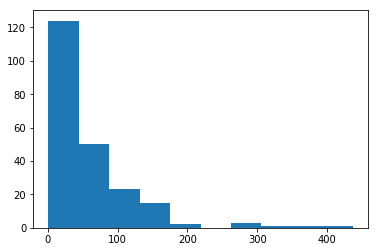

In [14]:
print('Distribution of thumbs up or down activity')
plt.hist(thumbs_df.select('count').rdd.flatMap(lambda x: x).collect());

In [15]:
sessions_df = df.select('userId', 'sessionId', 'itemInSession').groupBy('userId','sessionId').count()

Distribution of items in users sessions


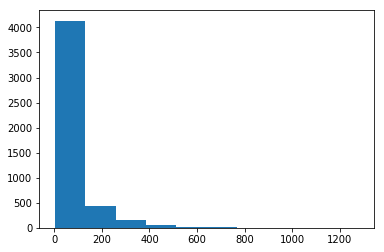

In [16]:
print('Distribution of items in users sessions')
plt.hist(sessions_df.select('count').rdd.flatMap(lambda x: x).collect());

### Review Null & Blank data

In [17]:
print('total count: ', df.count())
print('count with dropped null sessionId or userId: ', df.dropna(how = "any", subset = ["userId", "sessionId"]).count())

total count:  286500
count with dropped null sessionId or userId:  286500


## Clean Data
We have identified that although there are no null values for the userId, we do have a number of values with the userId blank.  However, since we want to be able to leverage this code on additional data sets we will go ahead and handle the case for null data as well as this case for blank strings.

In [18]:
# Remove rows where either userId or sessionId are blank
df = df.where('''
                length(userId) > 0
                AND
                length(sessionId) > 0
                ''')

In [19]:
#drop any rows with either sessionId or userId null
df = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [20]:
print('# of Records: ', df.count())
print('# of Users: ', df.select('userId').dropDuplicates().count())

# of Records:  278154
# of Users:  225


# Feature Engineering
Now that we are familiar with the data we will build out the following features that will be used in the modeling step.  Since we are interested in identifying the churn of individual users, our features will be constructed by a number of engagement metrics.

**Label**
- churn: represents any user who has had the 'Cancelation Confirmation' event.  This will be the target label for our modeling as we are interested in identifying users who may cancel their account

**Identifier**
- userId:  represents the unique users

**Engagement Metrics**
- no_thumbs:  represents the number of thumbs up or thumbs down that a user performed 
- no_playlist: represents the number of songs that a user has added to their playlists 
- no_friends: represents the number of friends added to their account
- no_help: represents the number of times a user had to access the help feature 
- no_settings: represents the number of times a user accessed the settings menu
- no_advert:  represents the number of times that a user received an ad
- no_errors:  represents the number of times a user received an error message
- avg_pages:  represents the average number of pages that the users accessed by session

In [21]:
#create a temp veiw to enable spark.sql functionality
df.createOrReplaceTempView("df_table")

In [22]:
#feature engineering script
engagement = spark.sql('''
SELECT userId,
       SUM(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS churn,
       SUM(CASE WHEN page = 'Thumbs Up' OR page = 'Thumbs Down' THEN 1 ELSE 0 END) AS no_thumbs,
       SUM(CASE When page = 'Add to Playlist' THEN 1 ELSE 0 END) AS no_playlist,
       SUM(CASE when page = 'Add Friend' THEN 1 ELSE 0 END) AS no_friends,
       SUM(CASE when page = 'Help' THEN 1 ELSE 0 END) AS no_help,
       SUM(CASE when page = 'Settings' THEN 1 ELSE 0 END) AS no_settings,
       SUM(CASE when page = 'Roll Advert' THEN 1 ELSE 0 END) AS no_advert,
       SUM(CASE when page = 'Error' THEN 1 ELSE 0 END) AS no_errors
FROM df_table AS engagement
GROUP BY userId
''')

sessions = spark.sql('''
select userId, ROUND(AVG(pages)) as avg_pages
from (select userId, sessionId, count(itemInSession) as pages from df_table group by userId, sessionId order by userId) 
group by userId''')

feature_set = engagement.join(sessions, ['userId'])

In [23]:
#The data set to model
feature_set.show()

+------+-----+---------+-----------+----------+-------+-----------+---------+---------+---------+
|userId|churn|no_thumbs|no_playlist|no_friends|no_help|no_settings|no_advert|no_errors|avg_pages|
+------+-----+---------+-----------+----------+-------+-----------+---------+---------+---------+
|100010|    0|       22|          7|         4|      2|          0|       52|        0|     54.0|
|200002|    0|       27|          8|         4|      2|          3|        7|        0|     79.0|
|   125|    1|        0|          0|         0|      0|          0|        1|        0|     11.0|
|   124|    0|      212|        118|        74|     23|         20|        4|        6|    166.0|
|    51|    1|      121|         52|        28|     12|         12|        0|        1|    246.0|
|     7|    0|        8|          5|         1|      1|          3|       16|        1|     29.0|
|    15|    0|       95|         59|        31|      8|         16|        1|        2|    152.0|
|    54|    1|      

# Modeling
We will use Random Forest and Logistic regression on our data set in order to predict the churn event.  We will setup a pipeline within cross validation to build the models.  The dataset will be split to train 80% of the data thereby leaving 20% of the data for testing.

The success of our model will be determined using precision, accuracy and F1 score.

In [24]:
#Create train and test datasets
train, test = feature_set.randomSplit([0.8, 0.2], seed=42)

In [25]:
#Create a list containing only dataset featrues, and then load these features into a vector assembler for modeling
feature_list = ['no_thumbs', 'no_playlist', 'no_friends', 'no_help', 'no_settings', 'no_advert', 'no_errors', 'avg_pages']
assembler = VectorAssembler(inputCols = feature_list, outputCol = 'feature_vect')


### Random Forest

In [26]:
#Build the random forest model pipline & parameters
rand_forest = RandomForestRegressor(labelCol = 'churn', featuresCol = 'feature_vect')
forest_pipeline = Pipeline(stages = [assembler, rand_forest])
forest_paramGrid = ParamGridBuilder() \
    .addGrid(rand_forest.numTrees, [10]) \
    .addGrid(rand_forest.maxDepth, [5,10]) \
    .build()
forest_crossval = CrossValidator(estimator = forest_pipeline,
                          estimatorParamMaps = forest_paramGrid,
                          evaluator = RegressionEvaluator(labelCol='churn'),
                          numFolds = 3)

In [27]:
#Fit the model with the training dataset, and then apply the model to the test dataset
f_cvModel = forest_crossval.fit(train)
f_predict = f_cvModel.transform(test)

In [28]:
#Take a look at the predictions to gain an uderstanding of how many churns were predicted
f_predictions = f_predict.withColumn('pred_round',F.round(f_predict.prediction,1))
f_predictions.groupBy('churn','pred_round').count().show()

+-----+----------+-----+
|churn|pred_round|count|
+-----+----------+-----+
|    0|       0.5|    1|
|    1|       0.3|    3|
|    0|       0.4|    1|
|    1|       0.5|    1|
|    1|       0.4|    1|
|    0|       0.6|    1|
|    0|       0.2|    8|
|    0|       0.0|    6|
|    0|       0.1|    4|
|    1|       0.2|    1|
|    0|       0.3|    5|
|    1|       0.1|    2|
+-----+----------+-----+



### Logistic Regression
We see that the above Random Forest model failed to predict the churn events, and since we do not have any predicted positives we will get precision and F1 as zero without having to perform many calculations.  We will now take a look at the Logistic Regression model to see if we do any better.

In [29]:
#Build model and parameters
log_reg = LogisticRegression(labelCol = 'churn', featuresCol = 'feature_vect')
reg_pipeline = Pipeline(stages = [assembler, log_reg])
reg_paramGrid = ParamGridBuilder() \
    .addGrid(log_reg.maxIter, [10,20]) \
    .build()
reg_crossval = CrossValidator(estimator = reg_pipeline,
                          estimatorParamMaps = reg_paramGrid,
                          evaluator = RegressionEvaluator(labelCol='churn'),
                          numFolds = 3)

In [30]:
#fit and transform the model
reg_cvModel = reg_crossval.fit(train)
reg_predict = reg_cvModel.transform(test)

In [31]:
#Take a look at the predictions to see if we get a better result
reg_predict.select('userId', 'churn', 'prediction').groupBy('churn', 'prediction').count().show()

+-----+----------+-----+
|churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|    8|
|    0|       0.0|   26|
+-----+----------+-----+



*At this point we can see that neither the Random Forest nor the Logistic regression models are capable of predicting a single churn event.  As such we will scale the features using standard scaler to see if the differing value ranges within the original data set are affecting the predictability.*

In [32]:
#scale the dataset
standardscaler = StandardScaler().setInputCol("feature_vect").setOutputCol("scaled_features")
feature_std_scaled = standardscaler.fit(assembler.transform(feature_set)).transform(assembler.transform(feature_set))
feature_std_scaled = feature_std_scaled.drop('feature_vect')                                                                                    

In [33]:
#Create train and test sets
scale_train, scale_test = feature_std_scaled.randomSplit([0.8, 0.2], seed=42)

In [34]:
#Instantiate model with pipeline and cross validation parameters
log_reg_scale = LogisticRegression(labelCol = 'churn', featuresCol = 'scaled_features')
reg_pipeline_scale = Pipeline(stages = [assembler, log_reg])
reg_paramGrid_scale = ParamGridBuilder() \
    .addGrid(log_reg_scale.maxIter, [10]) \
    .build()
reg_crossval_scale = CrossValidator(estimator = reg_pipeline_scale,
                          estimatorParamMaps = reg_paramGrid_scale,
                          #evaluator = RegressionEvaluator(labelCol='churn'),
                          evaluator = BinaryClassificationEvaluator(labelCol='churn'),          
                          numFolds = 3)

In [35]:
#Train and test model
reg_cvModel_scale = reg_crossval_scale.fit(scale_train)
reg_predict_scale = reg_cvModel_scale.transform(test)

In [36]:
#Investigate model results to see if the scaled data returned a better result
reg_predict_scale.where(reg_predict_scale.prediction > 0).show()

+------+-----+---------+-----------+----------+-------+-----------+---------+---------+---------+------------+-------------+-----------+----------+
|userId|churn|no_thumbs|no_playlist|no_friends|no_help|no_settings|no_advert|no_errors|avg_pages|feature_vect|rawPrediction|probability|prediction|
+------+-----+---------+-----------+----------+-------+-----------+---------+---------+---------+------------+-------------+-----------+----------+
+------+-----+---------+-----------+----------+-------+-----------+---------+---------+---------+------------+-------------+-----------+----------+



# Conclusion
Here we have evaluated the Sparkify data, and built a number of engagement related features.  It is possible that running these models on the full dataset would provide us better results.  However, we were unsuccessful establishing a model that would predict the churn events despite evaluating with Random Forest and Logistic Regression on the current dataset.  As both models have similar results, and we have experimented with a few different hyper parameters, it may be best to look directly at the features for improvement.

A number of possible improvements include:
- We can look to leverage statistical analysis to replace the counts of engagement by percentile.  Taking the no_thumbs column for example, instead of just counting all the values we could take the top 10% of users and replace their value with .9, for those between 10% and 20% we could replace with .8, etc.  This would reduce some of the variability of the values since the engagement for the user with the 95% highest thumbs ranking is likely not qualitatively different than the user with 98% highest thumbs ranking.
- We could leverage the datetime stamps for the data to get a value for how long a member has been a user.  It is possible that churn and life of an account may have some relevance
- We could drill down further into the time analysis and look specifically around the timeframe that the account was canceled as it is possible that there is a difference in activity as we approach the churn event.
- We could also leverage timestamp data to group our discreate users into users by time periods.  It may be that the activity in the first few weeks of the account creation have a direct impact on a future churn event
